## 畳み込み

畳み込みとは

あるピクセルと隣接するピクセルとの荷重和を作成する計算である。
この計算により、局所的なパターンが画像内の物体位置に関わらず出力に効果的である。

重み行列（カーネル）のスカラー積を出力していく
カーネルサイズは一般的に小さなサイズを使用し、二次元画像には３＊３、RBGの画像には３＊３＊３のカーネルが使用される。

カーネルの重みはnn.Linearの重みと同様に学習してい値である。そしてこのカーネルの重みは画像全体に渡り利用される。
そのためカーネルの重みは画像全体から影響を受けることになる。

全結合層を畳み込みに変更することで、下記のメリットがある

１．近傍における局所的な演算処理
２．移動不変性
３．パラメータを大幅に削減したモデル

## 畳み込みの使用

In [1]:
from torchvision import datasets
import torch
import torch.nn as nn
from torchvision import transforms


from matplotlib import pyplot as plt
import numpy as np

出力チャネルのサイズは任意の値が選択できる。
このチャネルの数が増えるほどパラメータが増加し、特徴量の検出も増大する。

カーネルのサイズはすべての方向に同じことが一般的だが、CTのボクセルのうち一つが異なる解像度であるような場合は、例外的に異なるサイズを使用する。

In [2]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [3]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [4]:
data_path = "../data/p1ch7/"
#引数は保存のパス、訓練用かテスト用か、pytorchで保存して良いか
#他にもSVHN ,COCO,Ominglotなどがある
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
cifar10 = datasets.CIFAR10(
            data_path, train=True, download=False, 
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4915, 0.4823, 0.4468),
                                     (0.1470, 0.2435, 0.2626))
            ]))

In [6]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [7]:
#cifar10の中から飛行機と鳥のみのdatasetsにする
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0,2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0,2]]

In [8]:
img, _ = cifar2[0]
img.shape

torch.Size([3, 32, 32])

In [11]:
output = conv(img.unsqueeze(0))
img.unsqueeze((0)).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

In [12]:
output[0, 0].shape

torch.Size([30, 30])

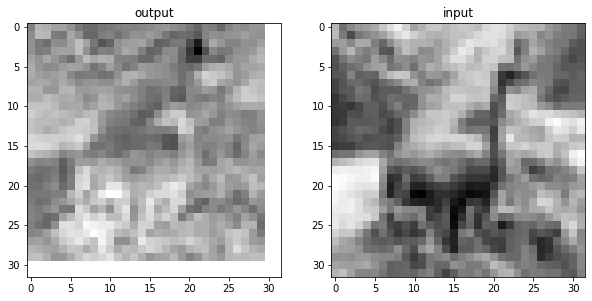

In [13]:
plt.figure(figsize=(10, 4.8))  # 本では省略
ax1 = plt.subplot(1, 2, 1)   # 本では省略
plt.title('output')   # 本では省略
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # 本では省略
plt.imshow(img.mean(0), cmap='gray')  
plt.title('input')  # 本では省略
#plt.savefig('Ch8_F2_PyTorch.png')  # 本では省略
plt.show()

#sharex = XXX：x軸の共有設定
#sharey = XXX：y軸の共有設定

入力に対して出力の画像サイズが小さくなっている。

## 境界のパディング

畳み込み処理では全ての方向に隣接したピクセルが存在する必要がある。
角の位置では上下どちらか、左右どちらかが存在しない。デフォルトではPyTorchではwidth - kernl_width +1 の位置までを取得する。
奇数サイズのカーネルではカーネルの幅の半分（今回は3//2=1)だけ各境界が小さくなった画像が出力された。

pytorchでは畳み込み時に境界領域にゼロになｋる架空のピクセルを作成して画像をパディングできる。
今回の件ではkernel_size=3*3, padeing=1 を指定するともとの画像と同じサイズの出力が得られる。

In [14]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))

In [15]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

画像サイズが変化しないことはスキップ接続や複雑な構造のモデルでテンソル同士の加減算が可能になる。

## 畳み込みの学習

手動でのパラメータ設定

In [16]:
#バイアスをゼロにする
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

In [17]:
conv.weight

Parameter containing:
tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]],

         [[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]],

         [[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]], requires_grad=True)

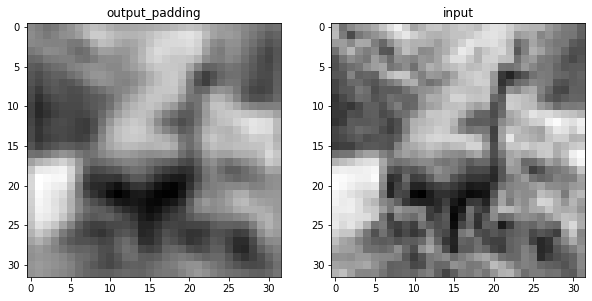

In [18]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # 本では省略
ax1 = plt.subplot(1, 2, 1)   # 本では省略
plt.title('output_padding')   # 本では省略
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # 本では省略
plt.imshow(img.mean(0), cmap='gray')  # 本では省略
plt.title('input')  # 本では省略
#plt.savefig('Ch8_F4_PyTorch.png')  # 本では省略
plt.show()

convの一定の重み（フィルタ）によってボケた画像が出力された。
畳み込みは出力ピクセル間に相関が生まれ、スムーズに画像が変化する

In [19]:
conv.weight.shape

torch.Size([1, 3, 3, 3])

In [20]:
#右側のピクセルから左側のピクセルを減算するフィルタ
#強度が異なる領域の垂直方向の境界になっているピクセルに対しては出力の値は大きな値となる。
#一方一様な領域であれば0に近い値となる。

#つまり垂直方向のエッジ検出のカーネルとなる
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

In [21]:
conv.weight

Parameter containing:
tensor([[[[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]]]], requires_grad=True)

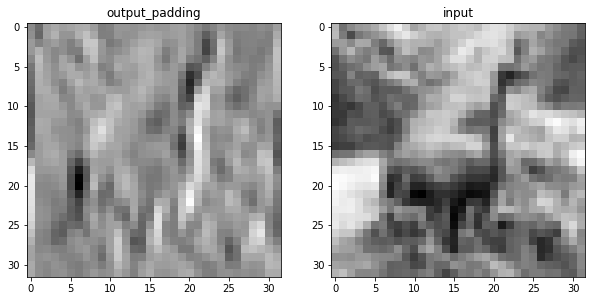

In [22]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # 本では省略
ax1 = plt.subplot(1, 2, 1)   # 本では省略
plt.title('output_padding')   # 本では省略
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # 本では省略
plt.imshow(img.mean(0), cmap='gray')  # 本では省略
plt.title('input')  # 本では省略
#plt.savefig('Ch8_F4_PyTorch.png')  # 本では省略
plt.show()

ディープラーニングでは最も効果的なカーネルの値を推定する。
学習は入力と出力の間のクロスエントロピー誤差を最小化するカーネルの値を推測していく。

畳み込みニューラルネットワークは複数チャネルの画像を別の複数チャネルの画像に変換する連続した層のフィルタ群を推定することである。
この異なるチャネルは異なる特徴量に対応する

## 深さとプーリング

CIFAR10の画像は小さく小さなカーネルで局所的な特徴を得た。
大きな画像で広い範囲の構造を把握したい場合はどうすれば良いか？

大きなカーネルを使用することで解決できるが、今度は元々の畳み込みの利点がなくなる。

畳み込みの利点を活かし、かつ大きな範囲の構造も把握するためには畳み込み後に畳み込みを繰り返しその間にダウンサンプリングをする方法がある

## ダウンサンプリング

画像を半分に縮小することは隣接している4つのピクセルを1つのピクセルにする

1.アベレージプーリング
2.マックスプーリング
3.ストライド畳み込み


In [23]:
img.shape

torch.Size([3, 32, 32])

In [24]:
#max_pooling
#画像を半分にしたいときはインスタンス引数に2を入れる

pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape , output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

はじめに小さなカーネルで畳み込みを行い、局所の特徴を掴み、
ダウンサンプリングした縮小後の画像で畳み込みを行う（元の画像で考えると倍の広い領域の特徴を掴む）

1つ目のカーネルは低レベルの特徴を、2つ目のカーネルは広い領域で効果的に動作し、前の特徴量を合成した特徴量を生成する。

このため複雑なケースでも対応できる

In [25]:
# ダウンサンプリングを入れたモデル
model = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.Tanh(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 8, kernel_size=3, padding=1),
        nn.Tanh(),
        nn.MaxPool2d(2),
)
model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Tanh()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Tanh()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [26]:
# 出力は8チャネルの8＊8の画像
model(img.unsqueeze(0)).shape

torch.Size([1, 8, 8, 8])

In [27]:
# 出力はとりか飛行機の2値にする必要がある
# 画像を32のベクトルにして、最後2値にする
model = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.Tanh(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 8, kernel_size=3, padding=1),
        nn.Tanh(),
        nn.MaxPool2d(2),
        nn.Linear(8 * 8 * 8, 32),
        nn.Tanh(),
        nn.Linear(32, 2)
)
model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Tanh()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Tanh()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Linear(in_features=512, out_features=32, bias=True)
  (7): Tanh()
  (8): Linear(in_features=32, out_features=2, bias=True)
)

In [28]:
# パラメータ確認
num_list = [p.numel() for p in model.parameters()]
sum(num_list), num_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [30]:
#エラーが出る
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

## nn.Moduleを継承してモデルを作成

モデル内で入力が二次元から一次元へと形式が変化するような場合はnn.sequeintal()では作成できない
（次元数が変化しないモデルを作成し。最後にLinearする手もある：キカガク参考）

nn.Moduleのサブクラス(子クラス）を用いて作成する

nn.Moduleを用いる場合はfoward関数を定義して、入力か出力への流れを記載する。
backwardはtorchのテンソルでは自動でおこなってくれる。

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# バッチ数が不明のためviewの引数は-1
# CNNの有名なモデルRESNETなどでは解像度を落としながら、チャネルを増やしていく（結果的にはサイズは縮小する）　
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [ ]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

In [ ]:
model(img.unsqueeze(0))

## functional API

パラメータが不要なサブモジュールも上の例ではインスタンス化して登録している。
pytorchでは「内部状態を持たない」といういみのfanctonalAPIが存在し、入力値を引数に入れると出力値が決定するモジュールがある。

nn.Linear には　nn.fanctional.linear 　　重みとバイアスと入力値を引数に入れて出力値が決まる。

In [ ]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
                           

In [ ]:
model = Net()
model(img.unsqueeze(0))

## 畳み込みニューラルネットの学習

ネットワークは外側がエポック、内側がバッチを取り出すDataLoaderによって二重にネストされている

各訓練ループは

１．入力をモデルに与える

２．損失を計算する

３．勾配をゼロにする（リセット）

４．loss.backfoward()ですべてのパラメータの損失に対する勾配を計算

５．オプティマイザで損失を低下する方向に更新


In [ ]:
#lossまでの確認
img, label = cifar2[0]
label = torch.tensor([label])
label.shape

In [ ]:
output = model(img.unsqueeze(0))
output.shape

In [ ]:
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(output, label

In [43]:
import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>
            outputs = model(imgs)  # <4>
            loss = loss_fn(outputs, labels)  # <5>
            optimizer.zero_grad()  # <6>            
            loss.backward()  # <7>
            optimizer.step()  # <8>
            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <10>
            # <1>
# Pythonに含まれているdatetimeモジュールを使用 
# 
# <2>
# 0からではなく1からn_epochsまで数字を振ったエポックに対するループ
# 
# <3>
# データローダーが作成したバッチの中のデータセットに対するループ
# 
# <4>
# モデルにバッチを投入し、…
# 
# <5>
# … そして最小化したい損失を計算を行う。
# 
# <6>
# 直近のラウンドの勾配を取り除いたあとに…
# 
# <7>
# … バックワード処理を行う。 
# つまり、ネットワークに学習して欲しいすべての パラメーターの勾配を計算します。
# 
# <8>
# モデルを更新
# 
# <9>
# エポックをまたいで損失を合算。 
# 勾配の情報を除くため、損失の値を.item()を用いて 
# Pythonの数値に変形するということを覚えておきましょう。 
# 
# <10>
# 訓練用のデータローダーの長さで除算し、バッチあたりの平均損失を得ます。 
# これは合計値よりも直感的な尺度ですね。 

In [44]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

# <1>
# DataLoaderがcifar2のデータセットのサンプルをバッチ化します。 
# また、データセットからサンプルを取得する順番をランダムにシャッフルしています。 
# 
# <2>
# ネットワークをインスタンス化し、…
# 
# <3>
# … 扱った確率的勾配降下の最適化関数を使用し…
# 
# <4>
# … 7.10節で扱った交差エントロピー損失を使用。
# 
# <5>
# 先程定義した訓練ループを呼び出す。 

2022-08-01 18:10:19.920411 Epoch 1, Training loss 0.6145077987461333
2022-08-01 18:10:38.440126 Epoch 10, Training loss 0.3287424462236417
2022-08-01 18:10:59.107284 Epoch 20, Training loss 0.293136403628975
2022-08-01 18:11:19.811265 Epoch 30, Training loss 0.27020680050181733
2022-08-01 18:11:40.428462 Epoch 40, Training loss 0.24779801331697757
2022-08-01 18:12:01.336116 Epoch 50, Training loss 0.22662982838169024
2022-08-01 18:12:22.384650 Epoch 60, Training loss 0.21089467173738843
2022-08-01 18:12:48.860087 Epoch 70, Training loss 0.19495652606532832
2022-08-01 18:13:14.170830 Epoch 80, Training loss 0.18241327958312004
2022-08-01 18:13:39.715001 Epoch 90, Training loss 0.17048105730372629
2022-08-01 18:14:05.607773 Epoch 100, Training loss 0.1558391595152533
